In [1]:
import os

import numpy as np
import pickle
import time
import pandas as pd

from tqdm.auto import tqdm

import INN
import torch
import torch.nn.functional as F
from torch.optim import Adam
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
train = True

# Data

In [4]:
with open('../../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

X_train = X_train
y_train = y_train

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (2521156, 28)
y_train.shape = (2521156, 2)


# Parameter Optimization

In [5]:
CINN_parameters = {
    'n_features': X_train.shape[1],
    'condition_features': y_train.shape[1],
    'device': device
}

loss_weights = {
    'dvg_factor': 1,
    'logdet_factor': 1,
    'rcst_factor': 1
}

lr = 5e-4

In [6]:
n_epochs = 6
batch_size = 1024

In [7]:
hyperparameter_search_space_boundaries = {
    'n_blocks': [1, 12],
    'n_coupling_network_hidden_layers': [1, 5],
    'n_coupling_network_hidden_nodes': [4, 512 + 256],
}

In [8]:
def scale_hyperparameters(hyperparameters):
    return np.array([h * (boundaries[1] - boundaries[0]) + boundaries[0] for h, boundaries in zip(hyperparameters, hyperparameter_search_space_boundaries.values())])

## Cross-Validation: Helper Functions

In [9]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
    return total_params

In [10]:
# def get_mean_CV_Score(score_function, hyperparameters, progress_bar_kwargs=None):
#     n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes = hyperparameters

#     kf = KFold(n_splits=5, shuffle=True, random_state=20210927)

#     log_loss_list = np.empty(5, dtype=np.float64)

#     for split_index, (fit_index, val_index) in enumerate(kf.split(X_train)):
#         # create splits
#         X_fit, X_val = X_train[fit_index], X_train[val_index]
#         y_fit, y_val = torch.Tensor(y_train[fit_index]).to(device), y_train[val_index]

#         # scale features
#         sc_X_fit = StandardScaler()
#         X_fit_scaled = torch.Tensor(sc_X_fit.fit_transform(X_fit)).to(device)
#         X_val_scaled = torch.Tensor(sc_X_fit.transform(X_val)).to(device)

#         # create classifier
#         inn = INN.INN(**INN_parameters, n_blocks=n_blocks, coupling_network_layers=[n_coupling_network_hidden_nodes] * n_coupling_network_hidden_layers).to(device)

#         inn.train()

#         # fit
#         inn.fit(
#             X_fit_scaled,
#             y_fit,
#             n_epochs=n_epochs,
#             batch_size=batch_size,
#             optimizer=Adam(inn.parameters(), lr=lr), 
#             loss_weights=loss_weights,
#             verbose=1,
#             progress_bar_kwargs=progress_bar_kwargs
#         )

#         inn.eval()

#         del X_fit_scaled, y_fit

#         # evaluate
#         n_batches = len(X_val) // batch_size
#         y_proba_pred = np.empty((0, 2))
#         for i_batch in range(n_batches + 1):
#             y_proba_pred_new = inn.forward(X_val_scaled[i_batch * batch_size: (i_batch+1) * batch_size])[0].detach().cpu().numpy()
#             y_proba_pred = np.concatenate([y_proba_pred, y_proba_pred_new], axis=0)

#         log_loss_list[split_index] = score_function(y_val, y_proba_pred)

#         del inn, X_val_scaled

#     return np.mean(log_loss_list)

In [11]:
# def expected_improvement(n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes, gp):
#     # compute E(q) and Var(q)
#     E_pred, Var_pred = gp.predict_noiseless(np.array([[n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes]]))

#     # compute gamma with the STD(q)
#     γ = (E_best - E_pred) / np.sqrt(Var_pred)

#     # return Expected Improvement
#     return (np.sqrt(Var_pred) * (γ * stats.norm.cdf(γ) + stats.norm.pdf(γ)))[0]

In [12]:
# def initialize_GP(n_samples, progress=0):
#     Q_init = np.empty((n_samples, len(hyperparameter_search_space_boundaries)))
#     E_init = np.empty((n_samples, 1))

#     # initialize with sobol sequence between 0 and 1
#     for i in range(n_samples):
#         for j, boundaries in enumerate(hyperparameter_search_space_boundaries.values()):
#             Q_init[i, j] = sb.i4_sobol(len(hyperparameter_search_space_boundaries), i)[0][j]# * (boundaries[1] - boundaries[0]) + boundaries[0]

#     # compute scores for the initial hyperparameters
#     for i, hyperparameters in enumerate(Q_init):

#         # skip the ones that have already been computed
#         if progress > i:
#             continue

#         # scale hyperparameters according to their bounds and convert them to integers
#         hyperparameters_scaled = scale_hyperparameters(hyperparameters).round().astype(int)

#         # print the status
#         hyperparameters_dict = {key: hyperparameters_scaled[i] for i, key in enumerate(hyperparameter_search_space_boundaries.keys())}
#         print(f'{i+1}/{len(Q_init)}: {hyperparameters_dict}')
#         time.sleep(0.35)
        
#         # compute cv score
#         E_init[i, :] = get_mean_CV_Score(log_loss, hyperparameters_scaled)
#         progress += 1

#         # save checkpoint
#         print('Storing Checkpoint...')
#         with open(f'../hyperparameter_results/INN.pt', 'wb') as file:
#             pickle.dump((Q_init, E_init), file)
#         with open(f'../hyperparameter_results/INN_progress.pt', 'wb') as file:
#             pickle.dump(progress, file)
#         print('Stored Checkpoint...')
#         clear_output(wait=True)

#     return Q_init, E_init

## Run Optimization

In [13]:
# initial_n_samples = 8#16
# additional_n_samples = 24#64

## GP-Prediction

In [14]:
# if train:
#     # load checkpoint if possible
#     if os.path.isfile('../hyperparameter_results/INN.pt') and os.path.isfile('../hyperparameter_results/INN_progress.pt'):
#         print('Loading Checkpoint...')
#         with open('../hyperparameter_results/INN.pt', 'rb') as file:
#             Q, E = pickle.load(file)
#         with open('../hyperparameter_results/INN_progress.pt', 'rb') as file:
#             progress = pickle.load(file)
#         print('Loaded Checkpoint')
#     else:
#         progress = 0
    
#     # if not all initial hyperparameters have been tested, continue testing them
#     if progress < initial_n_samples:
#         print(f"Initializing GP...")
#         time.sleep(0.3)
#         Q, E = initialize_GP(initial_n_samples, progress=progress)
#         progress = initial_n_samples

#     # main GP training loop
#     print('Training GP...')
#     for k in range(progress - initial_n_samples, additional_n_samples):
#         # train Gaussian Process
#         GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(3))
#         GP.optimize(messages=False)

#         # determine E_best (minimum value of E)
#         E_best = np.min(E)

#         # determine q_new (q with maximum expected improvement)
#         optimizer_output = opt.maximize(
#             lambda **kwargs: expected_improvement(gp=GP, **kwargs),
#             **{k: [0, 1] for k in hyperparameter_search_space_boundaries.keys()}
#         )[0]

#         # extract and scale new 'optimal' hyperparameters
#         q_new = np.array([optimizer_output[k] for k in hyperparameter_search_space_boundaries.keys()]).ravel()
#         q_new_scaled = scale_hyperparameters(q_new).round().astype(int)

#         # only for integer values: if the new hyperparameters have already been tested, the algorithm converged
#         for q in Q:
#             if (q_new == q).all():
#                 print('GP Converged early.')
#                 break

#         # print status
#         hyperparameters_dict = {key: q_new_scaled[i] for i, key in enumerate(hyperparameter_search_space_boundaries.keys())}
#         print(f'{k+1}/{additional_n_samples}: {hyperparameters_dict}')
#         time.sleep(0.3)

#         # add q_new to the training set Q
#         Q = np.vstack((Q, q_new))

#         # add value to E
#         E = np.vstack((E, get_mean_CV_Score(log_loss, q_new_scaled).reshape(-1, 1)))

#         # save checkpoint
#         progress += 1
#         print('Storing Checkpoint...')
#         with open(f'../hyperparameter_results/INN.pt', 'wb') as file:
#             pickle.dump((Q, E), file)
#         with open(f'../hyperparameter_results/INN_progress.pt', 'wb') as file:
#             pickle.dump(progress, file)
#         print('Stored Checkpoint...')

#         clear_output(wait=True)

#     print('Completed Training')

# else:
#     print(f'Loading Results...')
#     with open(f'../hyperparameter_results/INN.pt', 'rb') as file:
#         Q, E = pickle.load(file)
#     print(f'Loaded Results')

# GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(3))
# GP.optimize(messages=False);

## GP-Prediction

In [15]:
# Q_scaled = np.round([scale_hyperparameters(q) for q in Q]).astype(int)

In [16]:
# fig, axes = plt.subplots(1, 3, figsize=(30, 6))

# for i in range(3):
#     axes[i].scatter(Q_scaled[:5, i], E[:5])

In [17]:
# fig = plt.figure(figsize=(12, 8))
# fig.tight_layout()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel(r'n_blocks'); ax.set_ylabel(r'n_layers'); ax.set_zlabel(r'n_nodes')

# x = Q_scaled[:, 0]
# y = Q_scaled[:, 1]
# z = Q_scaled[:, 2]
# c = E[:, 0]

# img = ax.scatter(x, y, z, c=c, cmap=plt.get_cmap('Spectral'))
# fig.subplots_adjust(right=0.7)
# colorbar_ax = fig.add_axes([0.8, 0.2, 0.03, 0.6])
# fig.colorbar(img, cax=colorbar_ax, label='\nBCE')
# ax.view_init(elev=20., azim=220)

## Find 'Best' Hyperparameter

In [18]:
# def GP_log_loss_upper_confidence_bound(n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes, gp):
#     mean, var = gp.predict_noiseless(np.array([[n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes]]))
#     return mean + np.sqrt(var)

In [19]:
# hyperparameter_best_upper_confidence_bound = opt.minimize(
#     lambda **kwargs: GP_log_loss_upper_confidence_bound(gp=GP, **kwargs),
#     **{k: [0, 1] for k in hyperparameter_search_space_boundaries.keys()}
# )[0]

# hyperparameter_best_upper_confidence_bound_scaled = scale_hyperparameters(hyperparameter_best_upper_confidence_bound.values()).round().astype(int)

In [20]:
# hyperparameter_best_upper_confidence_bound_scaled

# Final Training

In [21]:
# scale features
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

#create classifier
# inn = INN.CINN(**INN_parameters, 
#     n_blocks=hyperparameter_best_upper_confidence_bound_scaled[0], 
#     coupling_network_layers=[hyperparameter_best_upper_confidence_bound_scaled[2]] * hyperparameter_best_upper_confidence_bound_scaled[1]
# )

cinn = INN.CINN(**CINN_parameters, 
    n_blocks=5, 
    coupling_network_layers=[512] * 2
)

X_train_scaled_cuda = torch.Tensor(X_train_scaled).to(device)
y_train_cuda = torch.Tensor(y_train).to(device)

# fit
cinn.fit(X_train_scaled_cuda, y_train_cuda, 
    n_epochs=16,
    batch_size=batch_size,
    optimizer=Adam(cinn.parameters(), lr=lr), 
    loss_weights=loss_weights,
    verbose=2,
);

del X_train_scaled_cuda, y_train_cuda

Epoch 10:  19%|█▉        | 479/2462 [00:11<00:47, 41.41it/s, batch=478/2462, weighted_loss=-81.276, dvg=+8.728, rcst=+0.395, logdet=-90.399]


KeyboardInterrupt: 

# Evaluation on Test Set

In [22]:
# IMPORTANT: Disable Dropout
cinn.eval();

In [27]:
with open('../../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)
y_test_cuda = torch.Tensor(y_test).to(device)

X_test.shape = (630290, 28)
y_test.shape = (630290, 2)


In [28]:
evaluation_results = {}

n_batches = len(X_test) // batch_size
z_pred = np.empty((len(X_test), 28))
for i_batch in tqdm(range(n_batches + 1)):
    z_pred[i_batch * batch_size: (i_batch+1) * batch_size] = cinn.forward(X_test_scaled[i_batch * batch_size: (i_batch+1) * batch_size], y_test_cuda[i_batch * batch_size: (i_batch+1) * batch_size]).detach().cpu().numpy()

del y_test_cuda

100%|██████████| 616/616 [00:02<00:00, 276.44it/s]


In [30]:
X_train_scaled = torch.Tensor(sc_X_train.transform(X_train)).to(device)
y_train_cuda = torch.Tensor(y_train).to(device)

n_batches = len(X_train) // batch_size
z_train_pred = np.empty((len(X_train), 28))
for i_batch in tqdm(range(n_batches + 1)):
    z_train_pred[i_batch * batch_size: (i_batch+1) * batch_size] = cinn.forward(X_train_scaled[i_batch * batch_size: (i_batch+1) * batch_size], y_train_cuda[i_batch * batch_size: (i_batch+1) * batch_size]).detach().cpu().numpy()

del X_train_scaled, y_train_cuda

100%|██████████| 2463/2463 [00:08<00:00, 280.87it/s]


# Latent Space

## Distribution

100%|██████████| 4/4 [00:12<00:00,  3.17s/it]


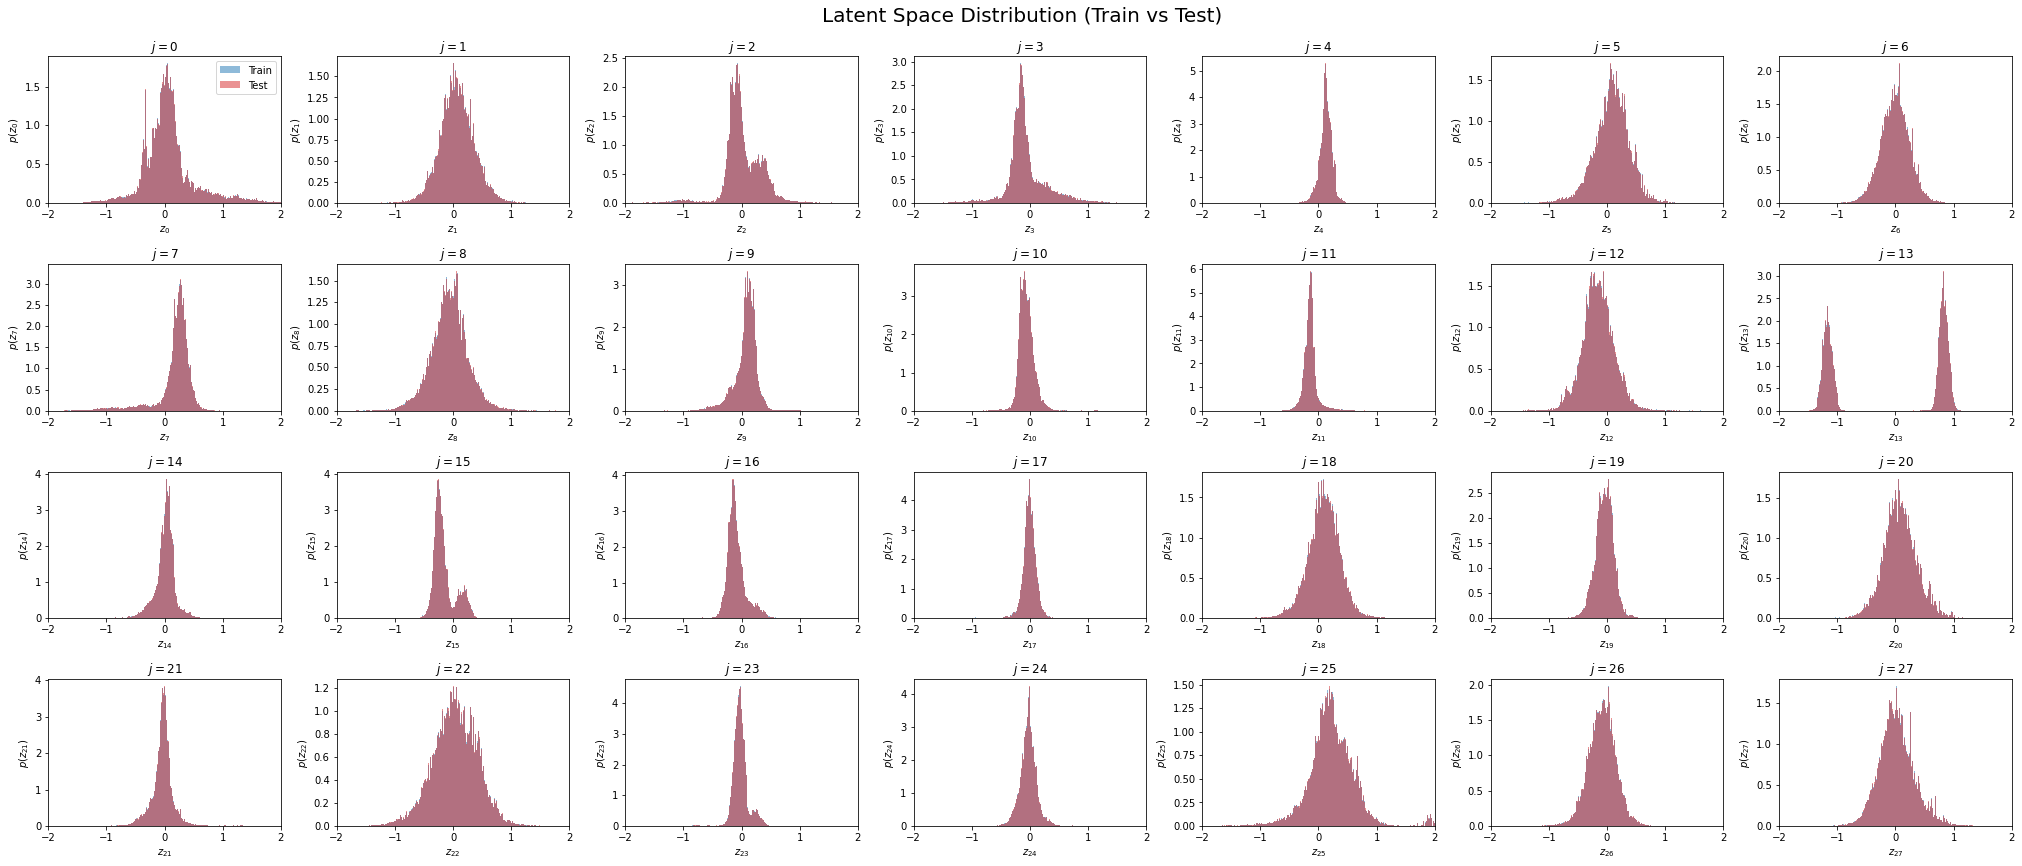

In [31]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(28, 12))
fig.suptitle('Latent Space Distribution (Train vs Test)\n', size=20)
fig.tight_layout(h_pad=4, w_pad=2.5)
bins = np.linspace(-2, 2, 256)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_train_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Train', color='tab:blue')
        axes[i_row][i_col].hist(z_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Test', color='tab:red')
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-2, 2); 
        if i_latent == 0: axes[i_row][i_col].legend();

In [36]:
keys = ['sex_female','age_0','age_18','age_50','age_65','race_native','race_asian','race_black','race_other','race_native_pacific','race_white','ethnicity_hispanic','case_onset_interval','symptom_status','used_bed_ratio','used_icu_ratio','rural-urban_Continuum Code_2013','urban_influence_code_2013','economic_typology_2015','pop_estimate_2019','less_hs_pct','hs_only_pct','some_college_pct','bachelor_higher_pct','unempl_rate','med_hh_income_19','med_hh_income_pct_state_total_19','poverty_pct_19', ]

def prettyX(X, index=None):
    return pd.DataFrame(X, columns=keys, index=index)

In [ ]:
y_zeros = torch.zeros((1, 2)).to(device)
y_h = torch.Tensor([[1, 0]]).to(device)
y_d = torch.Tensor([[0, 1]]).to(device)
y_hd = torch.Tensor([[1, 1]]).to(device)
z_zeros = torch.zeros((1, 26)).to(device)

## Reconstruction: Latent Zeros

In [ ]:
x_zeros_pred = inn.inverse(y_zeros, z_zeros).detach().cpu().numpy()
x_h_pred = inn.inverse(y_h, z_zeros).detach().cpu().numpy()
x_d_pred = inn.inverse(y_d, z_zeros).detach().cpu().numpy()
x_hd_pred = inn.inverse(y_hd, z_zeros).detach().cpu().numpy()

In [ ]:
x_all = np.concatenate([x_zeros_pred, x_h_pred, x_d_pred, x_hd_pred], axis=0)

In [ ]:
prettyX(sc_X_train.inverse_transform(x_all), index=['-', 'H', 'D', 'HD']).T

,-,H,D,HD
sex_female,0.509732,0.506886,0.510686,0.507891
age_0,0.023903,0.024029,0.024042,0.023902
age_18,0.901533,0.899983,0.902223,0.899822
age_50,0.049050,0.048853,0.044369,0.046002
age_65,-0.008550,-0.009199,-0.005976,-0.005699
race_native,-0.001312,-0.001277,-0.000949,-0.000876
race_asian,0.003214,0.003873,0.003134,0.003605
race_black,0.010569,0.010700,0.009801,0.009982
race_other,0.010437,0.010543,0.010601,0.010737
race_native_pacific,-0.000502,-0.000535,-0.000471,-0.000536


## Reconstruction: Encodings

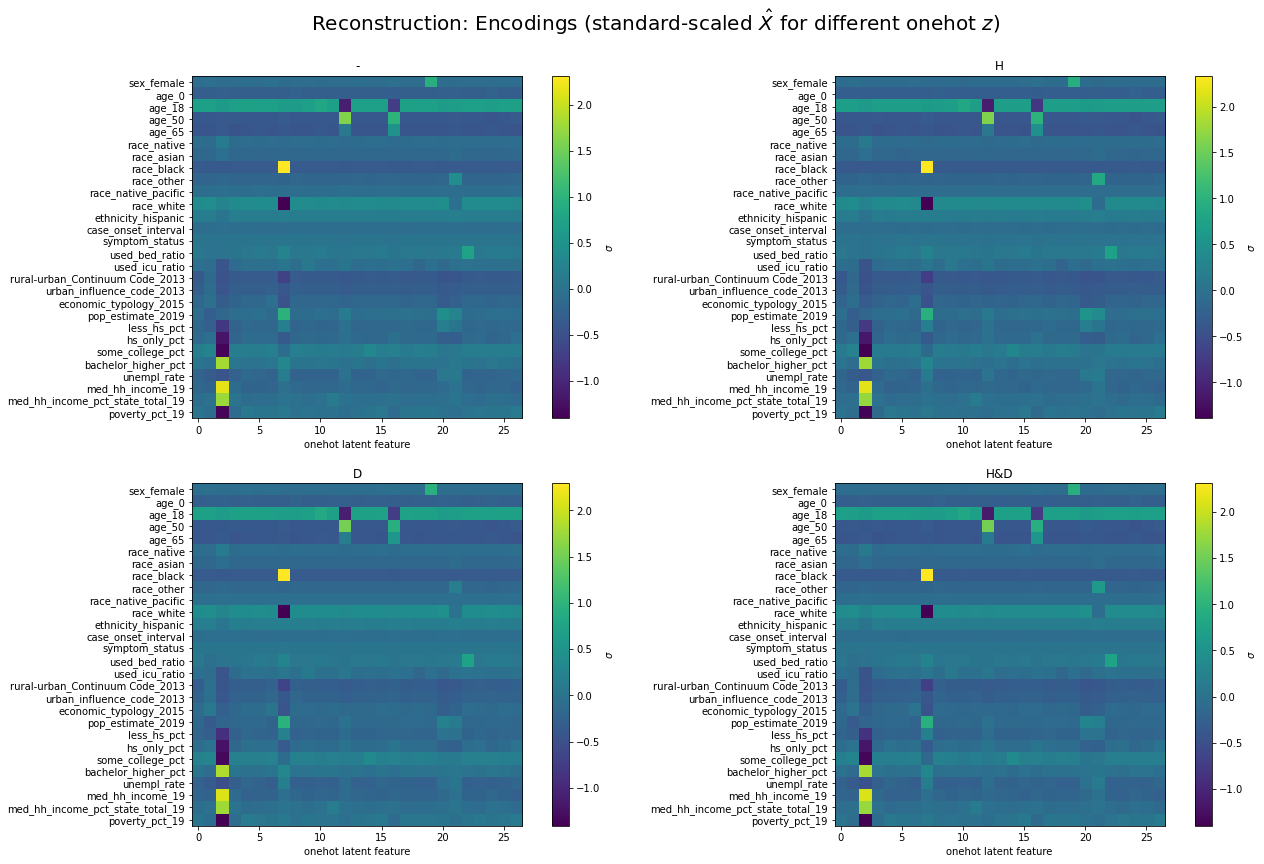

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(h_pad=5)
fig.suptitle(r'Reconstruction: Encodings (standard-scaled $\hat X$ for different onehot $z$)', size=20);
fig.subplots_adjust(top=0.9)

for i, y_combination, y_combination_name in zip(range(4), [[0,0], [1,0], [0,1], [1,1]], ['-', 'H', 'D', 'H&D']):
    y_zeros = torch.Tensor([y_combination]*27).to(device)
    z_onehot = torch.cat([torch.zeros((1, 26)), F.one_hot(torch.arange(0, 26))], dim=0).to(device)
    x_onehot = inn.inverse(y_zeros, z_onehot)

    img = axes[i//2][i%2].imshow(x_onehot.detach().cpu().T);
    fig.colorbar(img, ax=axes[i//2][i%2], label='$\sigma$');
    axes[i//2][i%2].set_xlabel('onehot latent feature'); axes[i//2][i%2].set_title(y_combination_name)
    axes[i//2][i%2].set_yticks(np.arange(28))
    axes[i//2][i%2].set_yticklabels(keys);

In [ ]:
x_self = {
    'sex_female': 0,
    'age_0': 0,
    'age_18': 1,
    'age_50': 0,
    'age_65': 0,
    'race_native': 0,
    'race_asian': 0,
    'race_black': 0,
    'race_other': 0,
    'race_native_pacific': 0,
    'race_white': 1,
    'ethnicity_hispanic': 0,
    'case_onset_interval': 0,
    'symptom_status': 1,
    'used_bed_ratio': 0.763, #https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Gesundheit/Krankenhaeuser/Tabellen/eckzahlen-krankenhaeuser.html
    'used_icu_ratio': 2237/2723, #https://www.intensivbetten-deutschland.de/#baden-wuerttemberg
    'rural-urban_Continuum Code_2013',
    'urban_influence_code_2013',
    'economic_typology_2015',
    'pop_estimate_2019': 548355, #https://de.statista.com/statistik/daten/studie/1172600/umfrage/entwicklung-der-gesamtbevoelkerung-im-rhein-neckar-kreis/
    'less_hs_pct': (0.035 + 0.286 + 0.235 + 0.04), #https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bildung-Forschung-Kultur/Bildungsstand/Tabellen/bildungsabschluss.html;jsessionid=5F506FE286D82795D2AD411A8EB8435D.live731
    'hs_only_pct': 25.5,
    'some_college_pct': ,
    'bachelor_higher_pct': (0.026 + 0.018 + 0.129 + 0.012),
    'unempl_rate' 0.04, #https://www.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/arbeitsmarkt-im-land-lebt-weiter-auf/
    'med_hh_income_19': 25_278, #https://de.wikipedia.org/wiki/Liste_der_Landkreise_nach_Einkommen
    'med_hh_income_pct_state_total_19',
    'poverty_pct_19': 0.119 #https://paritaet-bw.de/presseportal/pressemitteilungen/armut-baden-wuerttemberg-bei-119-prozent-der-paritaetische-baden-wuerttemberg-fordert-vom-land-sich-weiterhin-gegen-kinderarmut-stark-zu-machen
}

SyntaxError: invalid syntax (<ipython-input-47-703a117ff878>, line 18)

In [42]:
x_dead = X_test_scaled[y_test[:, 1] == 1][0].reshape(1, -1)
y_dead = torch.Tensor([[1, 1]]).to(device)
y_alive = torch.Tensor([[0, 0]]).to(device)

z_dead = cinn.forward(x_dead, y_dead)

x_reconstructed = cinn.inverse(z_dead, y_dead).detach().cpu().numpy()
x_alive = cinn.inverse(z_dead, y_alive).detach().cpu().numpy()

x_combined = np.concatenate([x_dead.detach().cpu().numpy(), x_reconstructed, x_alive], axis=0)

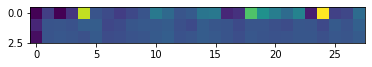

In [43]:
plt.imshow(x_combined)

In [44]:
prettyX(sc_X_train.inverse_transform(x_combined), index=['Dead', 'Reconstructed Alive', 'Reconstructed Alive']).T

,Dead,Reconstructed Alive,Reconstructed Alive
sex_female,9.679423e-09,0.207871,0.062894
age_0,2.080017e-09,0.093829,0.093326
age_18,2.912574e-08,0.530880,0.547922
age_50,-1.747322e-08,0.166598,0.185042
age_65,1.000000e+00,0.158057,0.092787
race_native,2.696014e-11,0.009001,0.005744
race_asian,-4.300146e-10,-0.010869,0.003276
race_black,1.137655e-09,0.063262,0.076589
race_other,4.855196e-10,0.045074,0.034335
race_native_pacific,1.334025e-11,0.003720,0.000905


In [ ]:
# IDEA: personal data -> latent representation -> set y = 0 -> inverse -> observe what changed

In [ ]:
for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')
    evaluation_results[y_label] = np.concatenate([1 - y_proba_pred[:, i].reshape(-1, 1), y_proba_pred[:, i].reshape(-1, 1)], axis=1)

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], evaluation_results[y_label][:, 1]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], evaluation_results[y_label][:, 1]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], evaluation_results[y_label][:, 1].round()).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], (evaluation_results[y_label][:, 1] > 0.5).astype(int)))
    print()

--- hosp ---
binary cross-entropy: 0.2144
brier loss: 0.0576
accuracy: 0.9313
confusion matrix:
[[584675    947]
 [ 42365   2303]]

--- death ---
binary cross-entropy: 0.0563
brier loss: 0.0115
accuracy: 0.9876
confusion matrix:
[[621469     17]
 [  7789   1015]]



In [ ]:
with open('../../evaluation_results/models/INN.pt', 'wb') as file:
    pickle.dump(evaluation_results, file)